# Домашняя работа 9. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

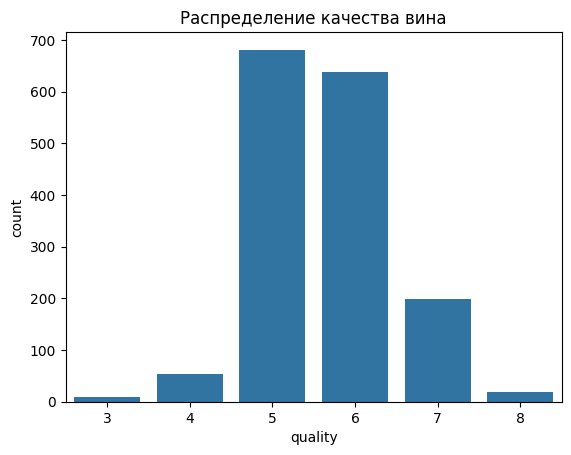

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv('../data/winequality-red.csv.gz', sep=';')


# #Визуализируем распределение целевой переменной
sns.countplot(x='quality', data=df)
plt.title('Распределение качества вина')
plt.show()

# # Делим на X и y
X = df.drop('quality', axis=1)
y = df['quality']

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "KNN + Scaling": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10)),
    "RidgeClassifier": RidgeClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "Bagging (all features)": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100, random_state=42),
    "Bagging (max_features=0.5)": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100, max_features=0.5, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f}")

KNN: 0.5122
KNN + Scaling: 0.5816
RidgeClassifier: 0.5835
DecisionTree: 0.6179
Bagging (all features): 0.6980
Bagging (max_features=0.5): 0.6948
RandomForest: 0.7017


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

## ОТВЕТ
Масштабирование важно для KNN, потому что оно основано на расстояниях. Без него — признаки с большими значениями «перетягивают» вклад.

Деревьям пофиг на масштаб — они не используют расстояния, а только сравнения признаков.

Бэггинг с половиной признаков даёт выигрыш: у деревьев появляется больше разнообразия → композиция работает лучше.

Самое большое отклонение — у одиночного дерева, потому что оно нестабильно, чувствительно к данным.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

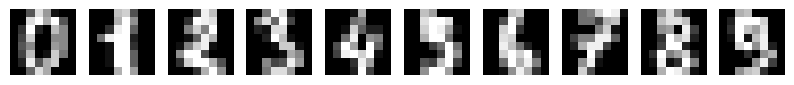

In [10]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
X_digits, y_digits = digits.data, digits.target

# Рисуем первые 10 картинок
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.axis('off')
plt.show()

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from math import sqrt

n_features = X_digits.shape[1]
sqrt_n = int(sqrt(n_features))

models_digits = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "Bagging (all features)": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100, random_state=42),
    "Bagging (max_features=sqrt(N))": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100, max_features=sqrt_n, random_state=42),
    "Bagging (base max_features=sqrt(N))": BaggingClassifier(
        estimator=DecisionTreeClassifier(max_features='sqrt', random_state=42),
        n_estimators=100, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models_digits.items():
    scores = cross_val_score(model, X_digits, y_digits, cv=10, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f}")

DecisionTree: 0.8336
Bagging (all features): 0.9271
Bagging (max_features=sqrt(N)): 0.9299
Bagging (base max_features=sqrt(N)): 0.9549
RandomForest: 0.9494


### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?


## ОТВЕТ
max_features в Bagging ограничивает, какие признаки доступны модели целиком.

max_features в дереве ограничивает разбиения внутри дерева.

Это сильно влияет на разнообразие и качество. Первый влияет на "видимость", второй — на глубину и путь дерева.

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

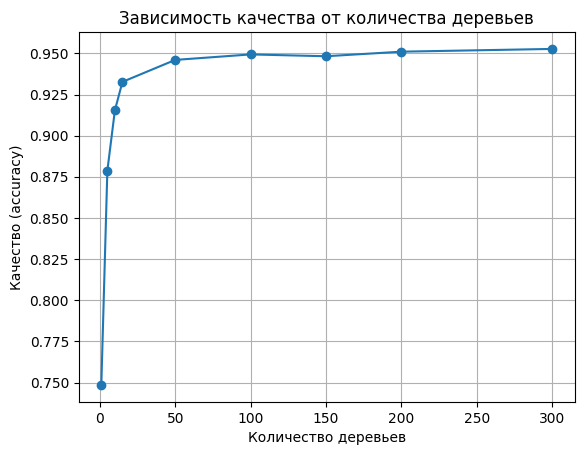

In [13]:
trees_range = [1, 5, 10, 15, 50, 100, 150, 200, 300]
rf_scores = []

for n in trees_range:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(clf, X_digits, y_digits, cv=10, scoring='accuracy')
    rf_scores.append(np.mean(score))

plt.plot(trees_range, rf_scores, marker='o')
plt.xlabel("Количество деревьев")
plt.ylabel("Качество (accuracy)")
plt.title("Зависимость качества от количества деревьев")
plt.grid(True)
plt.show()

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [ ]:
max_features_range = list(range(1, 65, 5))
scores_mf = []

for mf in max_features_range:
    clf = RandomForestClassifier(n_estimators=100, max_features=mf, random_state=42)
    score = cross_val_score(clf, X_digits, y_digits, cv=10, scoring='accuracy')
    scores_mf.append(np.mean(score))

plt.plot(max_features_range, scores_mf, marker='o')
plt.xlabel("max_features")
plt.ylabel("Качество (accuracy)")
plt.title("Зависимость качества от max_features")
plt.grid(True)
plt.show()

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?


### ОТВЕТ
5000 деревьев — это оверхед. Качество растёт до определённого порога, потом — плато. Ресурсы тратятся, а прироста нет.

Качество зависит от max_features — меньше признаков → больше разнообразия → меньше переобучения.

Причина в случайности. Меньше признаков — больше различий между деревьями.

Глубокие деревья могут переобучаться, но если деревьев много, то ансамбль будет устойчивее. В RandomForest лучше делать неглубокие деревья с ограничением.

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)